In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
%matplotlib inline

In [3]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [4]:
disp_figs = True

In [5]:
M = 4 # Number of Spiking motifs
N = 10 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 40 # hz
pg_fr = 4 # hz
background_noise_fr = 0 # h

np.random.seed(41)

In [6]:
# for matplotlib
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
len(colors)

10

# Generate the PG Kernels


In [7]:
# I will try and do this with dense and sparse representations at the same time
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)

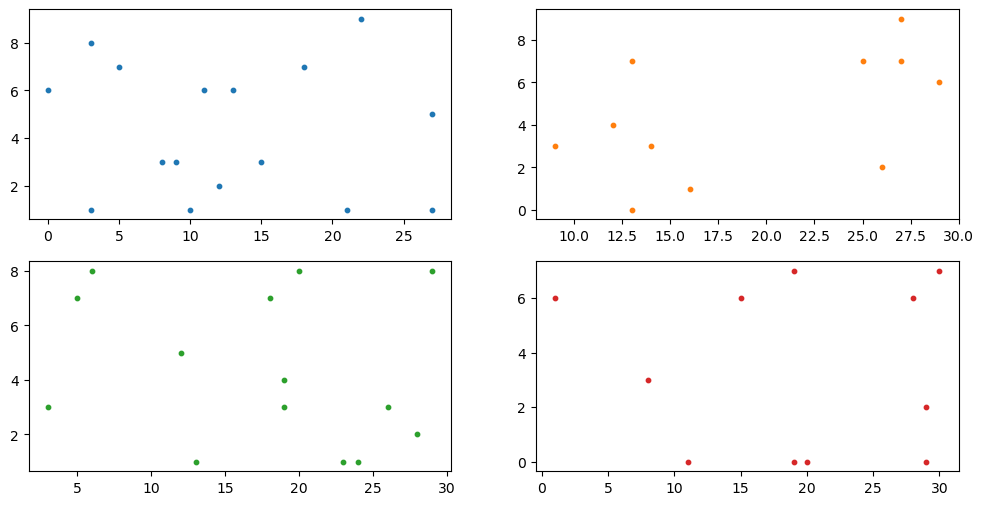

In [8]:

if disp_figs:
    %matplotlib inline
    fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
    [ax[k].scatter(K_sparse[1][K_sparse[2]==i], K_sparse[0][K_sparse[2]==i],c=colors[i],s=10) for i,k in enumerate(['A','B','C','D'])]

# Generate the PG occurrences

In [9]:
# I suppose I can also do this in sparse and dense
# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)

In [10]:
B_sparse[0]

array([0, 0, 0, 0, 0, 1, 1, 1, 2, 3, 3], dtype=int64)

In [11]:
colors[B_sparse[0]]

array(['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e',
       '#ff7f0e', '#ff7f0e', '#2ca02c', '#d62728', '#d62728'], dtype='<U7')

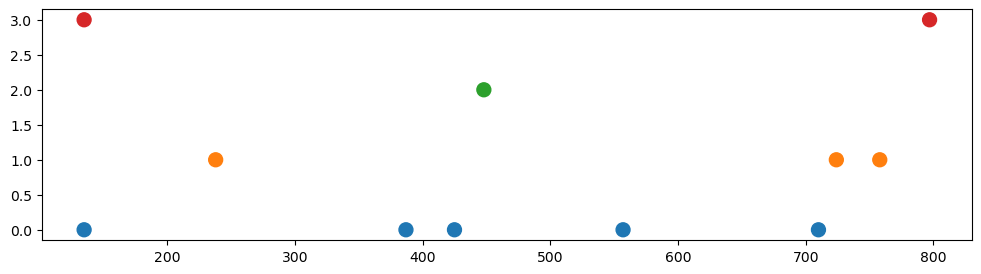

In [12]:
plt.figure(figsize=(12,3))
plt.scatter(B_sparse[1],B_sparse[0],c=colors[B_sparse[0]],s=100)
plt.show()

# Convolve the PG kernels with the PG firing times

In [13]:
background_noise_fr

0

In [14]:
# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,-1] = np.random.randint(0,999,(N,T+D))
A_dense[...,-1] = (A_dense[...,-1] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b]
    
A_dense.shape
# A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1
A_dense.shape

(10, 1031)

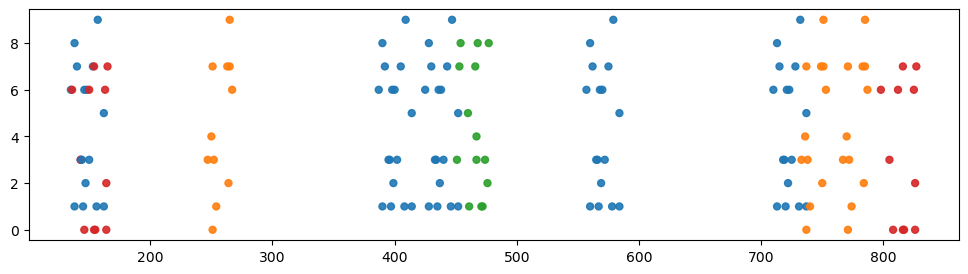

In [15]:
%matplotlib inline
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
plt.show()

# Sanity Check

Let's start with a proof of concept by convolving the answers with the full raster plot :)

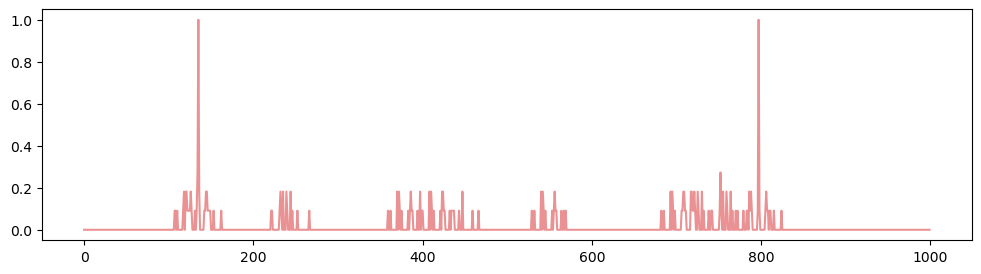

In [16]:
test = np.zeros((T,M))
%matplotlib inline
for j in range(M):
    for i in range(T):
        test[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    test[:,j] = test[:,j]/np.max(test[:,j])
plt.figure(figsize=(12,3))
i = 3
plt.plot(test[:,i],color=colors[i],alpha=0.5)

# Unsupervised Learning

so... why don't I try the flawed window shift method? Even though this loses the spike information

In [17]:
window_dim = (int(np.ceil(D/2)), N)
valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0])

 should make sure to have the labels handy...

In [67]:
M_labels = A_sparse[2][valid_spikes]
N_labels = A_sparse[0][valid_spikes]
T_labels = A_sparse[1][valid_spikes]
windows = np.zeros((len(T_labels), N, window_dim[0]*2))
for i,window_time in enumerate(T_labels):
    windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]
#     windows[i,N_labels[i],window_dim[0]] = 2
print('spikes: %d, neurons: %s, depth: %a' %windows.shape)

spikes: 149, neurons: 10, depth: 32


In [68]:
windows.shape

(149, 10, 32)

# Cross correlation of the windows??

In [90]:
test = windows[N_labels==2]
test.shape

(11, 10, 32)

In [91]:
result = np.zeros((test.shape[0],test.shape[0],10,32))

In [103]:
x = np.zeros((len(test),len(test)))
for i in range(test.shape[0]):
    for j in range(test.shape[0]):
        result[i,j,...] = test[i]*test[j] 
        x[i,j] = np.sum(test[i]*test[j])/ max(np.sum(test[i]),np.sum(test[j]))


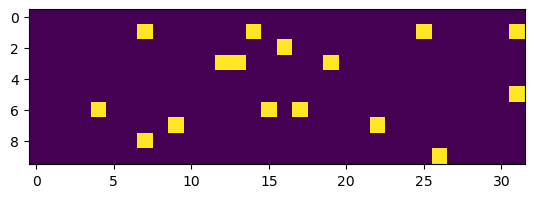

In [98]:
plt.figure()
plt.imshow(result[7,0])

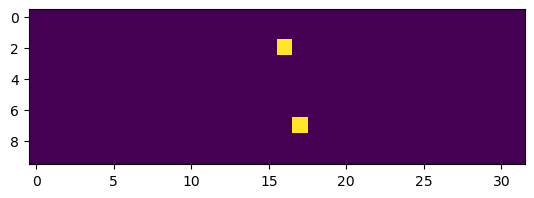

In [99]:
plt.figure()
plt.imshow(result[8,1])

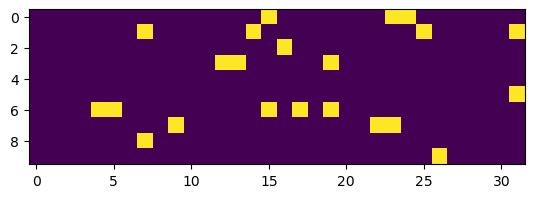

In [100]:
plt.figure()
plt.imshow(result[0,0])

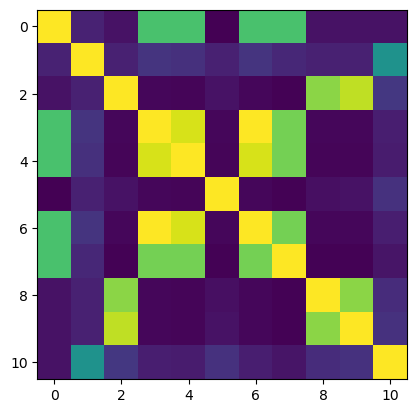

In [105]:
plt.figure()
plt.imshow(x)

For each spike, I can guess if there is a pattern repeating around it based off of the dot product between the two windows of that point... So in the above matrix I see that 5 spikes correlate highly with 4 OTHER spikes, 2 spikes correlate with just 1 OTHER spike, and 3 spikes correlate with 2 OTHER spikes. so... How can I take this data and do some clustering with it? hmmmmm...



# Hierarchical Clustering

In [107]:
dissimilarity = 1 - x
cutoff = 0.5


array([[0.        , 0.86363636, 0.90909091, 0.27272727, 0.27272727,
        0.95454545, 0.27272727, 0.27272727, 0.90909091, 0.90909091,
        0.90909091],
       [0.86363636, 0.        , 0.86666667, 0.8125    , 0.82352941,
        0.86666667, 0.8125    , 0.85      , 0.86666667, 0.86666667,
        0.46666667],
       [0.90909091, 0.86666667, 0.        , 0.9375    , 0.94117647,
        0.90909091, 0.9375    , 0.95      , 0.16666667, 0.09090909,
        0.8       ],
       [0.27272727, 0.8125    , 0.9375    , 0.        , 0.05882353,
        0.9375    , 0.        , 0.2       , 0.9375    , 0.9375    ,
        0.875     ],
       [0.27272727, 0.82352941, 0.94117647, 0.05882353, 0.        ,
        0.94117647, 0.05882353, 0.2       , 0.94117647, 0.94117647,
        0.88235294],
       [0.95454545, 0.86666667, 0.90909091, 0.9375    , 0.94117647,
        0.        , 0.9375    , 0.95      , 0.91666667, 0.90909091,
        0.81818182],
       [0.27272727, 0.8125    , 0.9375    , 0.        , 0.

In [115]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [110]:
debug = linkage(dissimilarity, method='complete')

C:\Users\miles\AppData\Local\Temp\ipykernel_6624\1703429331.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  debug = linkage(dissimilarity, method='complete')


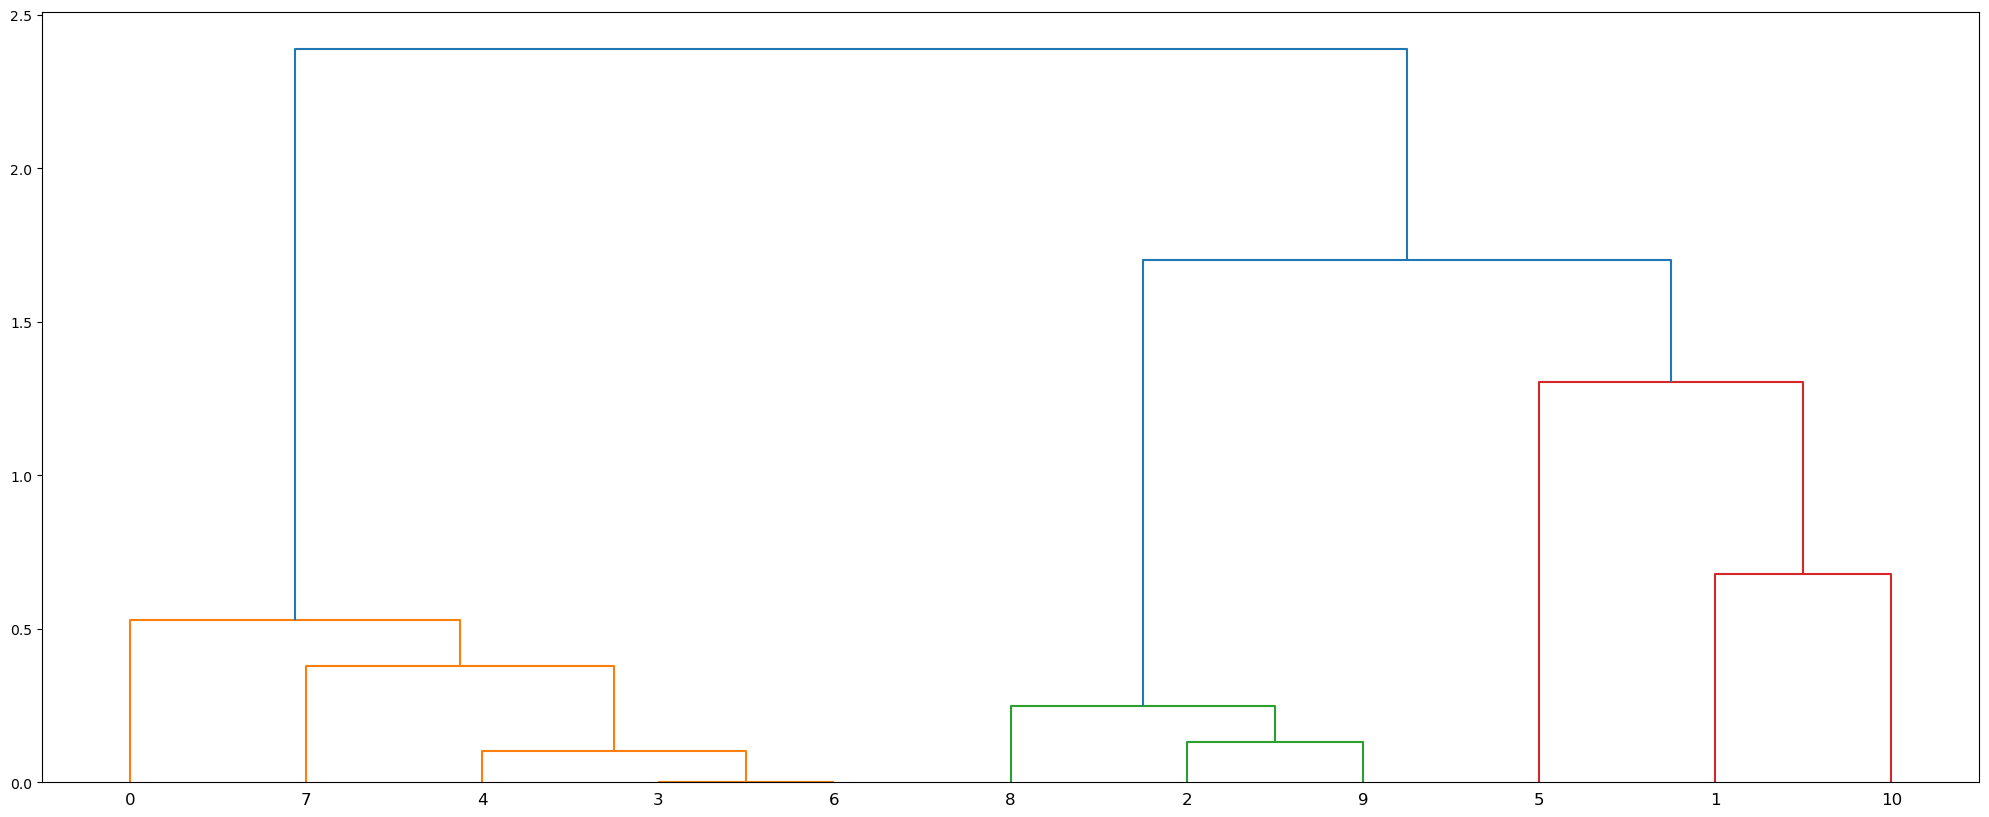

In [116]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(debug)

In [117]:
debug

array([[ 3.        ,  6.        ,  0.        ,  2.        ],
       [ 4.        , 11.        ,  0.10300681,  3.        ],
       [ 2.        ,  9.        ,  0.12984415,  2.        ],
       [ 8.        , 13.        ,  0.24992653,  3.        ],
       [ 7.        , 12.        ,  0.377607  ,  4.        ],
       [ 0.        , 15.        ,  0.52978624,  5.        ],
       [ 1.        , 10.        ,  0.67944941,  2.        ],
       [ 5.        , 17.        ,  1.30201384,  3.        ],
       [14.        , 18.        ,  1.69917943,  6.        ],
       [16.        , 19.        ,  2.38809347, 11.        ]])

since I don't have wifi... let's say I get to the step of having the spikes clustered...
Next steps are to begin labelling the real spikes from the windows I generated...

In [119]:
clusters = [[0,7,4,3,6],[8,2,9],[5],[1,10]]
labels = np.array([0,3,1,0,0,2,0,0,1,1,3])
generated_labels = np.zeros_like(M_labels)

For testing:
Next step is to do this same clustering thing for another neuron. Then I would have two 

One method is to save a template of either the average, or absolute template encoded by all of the spikes belonging to that cluster. Then, when I have a second spike train clustered. I can compare the average template and compare it across neuron addresses ( or maybe across all neuron addresses?) then I can say which "clusters" belong to the same cluster. In order to do this comparison I would need to do a correlation of the templates... I suppose I would just take the value of maximum correlation? or maybe if I know the relative spike times I can just crop and pad the windows with zeros and compare the windows directly with each other. I can do that for both windows, and normalize according to the cropped/padded window with the most spikes?

This will leave me with two things, the labels for each spike in the raster plot of which STM it belongs to, and either the average of absolute STM template. What I really want though is are the times of the STM's... 

Since I have labels for each spike, maybe I could use a linear regression function to train the algorithm to 
